# Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import make_blobs, make_circles, make_regression, make_moons
from sklearn.metrics import accuracy_score

# Code

In [3]:
class Criterion():
    
    def __init__(self):
        pass
    
    def get_predict_val(self, target: np.array):
        raise NotImplementedError
        
    def get_score(self, tatget: np.array):
        raise NotImplementedError
        
    def get_best_split(self, feature: np.array, target: np.array) -> tuple([float, float]):
        indixes = feature.argsort()
        target_str = target[indixes]
        N = len(target_str)
        
        Q_best = -np.inf
        i_best = 0
        H = self.get_score(target_str)
        
        for i in range(1, N): # without max and min value
            H_lhs = self.get_score(target_str[:i])
            H_rhs = self.get_score(target_str[i:])
            Q = H - i / N * H_lhs - (N-i) / N * H_rhs
            
            if Q > Q_best:
                Q_best = Q
                i_best = i
                
        threshold = (feature[i_best] + feature[i_best-1]) / 2
        return threshold, Q_best

In [4]:
class GiniCriterion(Criterion):
    
    def __init__(self, n_classes: int):
        self.n_classes = n_classes
        
    def get_predict_val(self, target: np.array) -> np.array:
        return np.bincount(target, minlength=self.n_classes) / len(target)
    
    def get_score(self, target: np.array) -> np.array:
        p = self.get_predict_val(target)
        return 1 - np.sum(p*p)

In [5]:
class EntropyCriterion(Criterion):
    
    EPS = 1e-8
    
    def __init__(self, n_classes: int):
        self.n_classes = n_classes
        
    def get_predict_val(self, target: np.array) -> np.array:
        return np.bincount(target, minlength=self.n_classes) / len(target)
    
    def get_score(self, target: np.array) -> np.array:
        p = self.get_predict_val(target)
        return - np.sum(p * np.log(p + self.EPS))

In [6]:
class MSECriterion(Criterion):
    
    def __init__(self, n_classes: int):
        self.n_classes = n_classes
        
    def get_predict_val(self, target: np.array) -> np.array:
        return np.mean(target)
    
    def get_score(self, target: np.array) -> np.array:
        mean = self.get_predict_val(target)
        return np.mean(np.square(target - mean))

In [7]:
class TreeNode():
    
    
    def __init__(self, criterion: Criterion, depth: int = 0):
        self.criterion = criterion
        self.lhs_node = None
        self.rhs_node = None
        self.depth = depth
        
        self.feature = None
        self.threshold = None
        self.predict_val = None
        
    def is_terminal(self):
        return (self.lhs_node is None) and (self.rhs_node is None)
    
    def get_best_feature(self, x: np.array, y: np.array) -> tuple([int, float, float]):
        Q_best = -np.inf
        threshold_best = 0
        feature_best = 0
        
        
        for feature in range(x.shape[1]):
            threshold, Q = self.criterion.get_best_split(x[:, feature], y)
            if Q > Q_best:
                Q_best = Q
                feature_best = feature
                threshold_best = threshold
                
        self.feature = feature_best
        self.threshold = threshold_best
        return feature_best, threshold_best, Q_best
        
    def get_indicator_mask(self, x, threshold) -> np.array:
        return x <= threshold
    
    def split(self, x, y):
        feature, threshold, q = self.get_best_feature(x, y)
        rhs_mask = self.get_indicator_mask(x[:, feature], threshold)
                
        lhs_node = TreeNode(self.criterion, self.depth+1)
        lhs_node.predict_val = self.criterion.get_predict_val(y[rhs_mask])
        
        rhs_node = TreeNode(self.criterion, self.depth+1)
        rhs_node.predict_val = self.criterion.get_predict_val(y[~rhs_mask])
        return rhs_mask, lhs_node, rhs_node

In [8]:
class Tree:
    
    def __init__(self, criterion: Criterion, max_depth: int = None, min_leaf_size: int = None):
        self.max_depth = max_depth
        self.min_leaf_size = min_leaf_size
        self.criterion = criterion
        self.root = TreeNode(self.criterion, 1)
        
    def insert(self, node: TreeNode, X: np.array, y: np.array):
        if node is None:
            raise NotImplementedError
            
        if np.unique(y).shape[0] <= 1:
            return None
        
        if self.max_depth is not None and node.depth >= self.max_depth:
            return None
        
        if self.min_leaf_size is not None and self.min_leaf_size > len(y) :
            return None
        
        mask, lhs_node, rhs_node = node.split(X, y)
        
        node.lhs_node = lhs_node
        self.insert(node.lhs_node, X[mask], y[mask])
        
        node.rhs_node = rhs_node
        self.insert(node.rhs_node, X[~mask], y[~mask])
        
    def build_tree(self, X, y):
        self.insert(self.root, X, y)
        
    def _predict(self, node, X, preds, inds):
        if node.is_terminal():
            preds[inds] = node.predict_val
        else:
            mask = node.get_indicator_mask(X[:, node.feature], node.threshold)
            self._predict(node.lhs_node, X[mask], preds, inds[mask])
            self._predict(node.rhs_node, X[~mask], preds, inds[~mask])

In [9]:
class ClassificationTree(Tree):
    
    def __init__(self, max_depth: int = None, min_leaf_size: int = None, criterion: str = 'gini'):
        super().__init__(criterion = Criterion(), max_depth=max_depth, min_leaf_size=min_leaf_size)
        if criterion not in ['gini', 'entropy']:
            raise NotImplementedError
        self.criterion = criterion
        self.n_classes = None
        
    def fit(self, X, y):
        self.n_classes = np.unique(y).shape[0]
        if self.criterion == 'gini':
            self.root.criterion = GiniCriterion(self.n_classes)
        elif self.criterion == 'entropy':
            self.root.criterion = EntropyCriterion(self.n_classes)
        self.build_tree(X, y)
        return self
    
    def predict_proba(self, X):
        preds = np.zeros(shape=(X.shape[0], self.n_classes))
        self._predict(self.root, X, preds, np.arange(X.shape[0]))
        return preds
    
    def predict(self, X):
        preds = self.predict_proba(X)
        return np.argmax(preds, axis=1)

In [10]:
class RegressionTree(Tree):
    
    def __init__(self, max_depth: int = None, min_leaf_size: int = None, criterion: str = 'mse'):
        super().__init__(criterion = Criterion(), max_depth=max_depth, min_leaf_size=min_leaf_size)
        if criterion not in ['mse']:
            raise NotImplementedError
        self.criterion = criterion
        self.n_classes = None
        
    def fit(self, X, y):
        self.n_classes = np.unique(y).shape[0]
        if self.criterion == 'mse':
            self.root.criterion = MSECriterion(self.n_classes)
        self.build_tree(X, y)
        return self
    
    def predict(self, X):
        preds = np.zeros(shape=(X.shape[0]))
        self._predict(self.root, X, preds, np.arange(X.shape[0]))
        return preds

## Helpers

In [11]:
def plot_decision_surface(clf, X, y, plot_step=0.2, cmap='Spectral', figsize=(10, 8)):
    # Plot the decision boundary
    plt.figure(figsize=figsize)
    
    n_classes = len(set(y))
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.5)    
    y_pred = clf.predict(X)

    # Plot the training points
    plt.scatter(*X[y_pred == y].T, marker='.', s=70,
                c=y[y_pred == y], cmap=cmap, alpha=0.9, label='correct')
    plt.scatter(*X[y_pred != y].T, marker='x', s=50,
                c=y[y_pred != y], cmap=cmap, label='errors')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis("tight")
    plt.legend(loc='best')
    print("Accuracy =", accuracy_score(y, y_pred))

In [12]:
def plot_regression(clf, X, y, cmap='Spectral', figsize=(10, 8)):
    plt.figure(figsize=figsize)
    t = np.arange(-3, 3, 0.1).reshape(-1,1)
    y_pred = clf.predict(t)
    plt.scatter(X, y)
    plt.plot(t, y_pred, color='red')

## Classification

### Clusters

Accuracy = 1.0


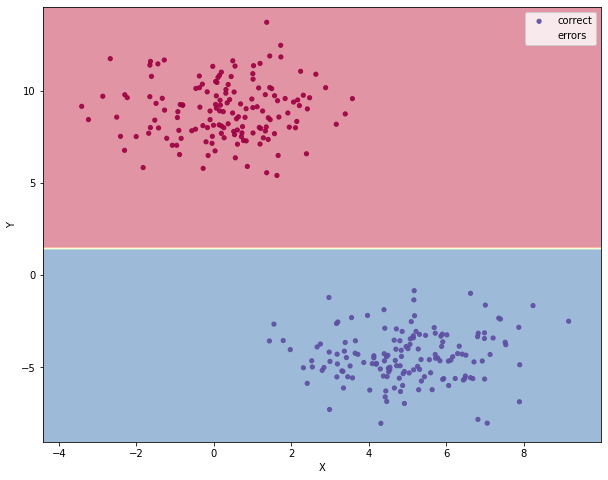

In [13]:
X, y = make_blobs(n_samples=300, n_features=2, cluster_std=1.5, centers=2, random_state=23)
tree = ClassificationTree(criterion='entropy', max_depth=6)
tree.fit(X, y)
plot_decision_surface(tree, X, y)

Accuracy = 0.8466666666666667


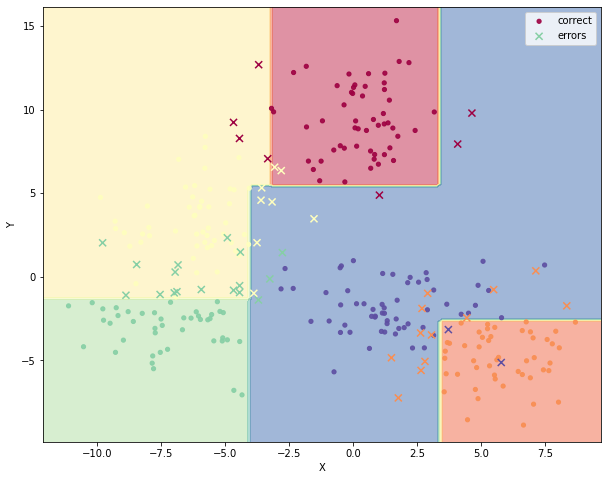

In [14]:
X, y = make_blobs(n_samples=300, n_features=2, cluster_std=2, centers=5, random_state=23)
tree = ClassificationTree(criterion='gini', max_depth=6, min_leaf_size=10)
tree.fit(X, y)
plot_decision_surface(tree, X, y)

### Circles

Accuracy = 0.91


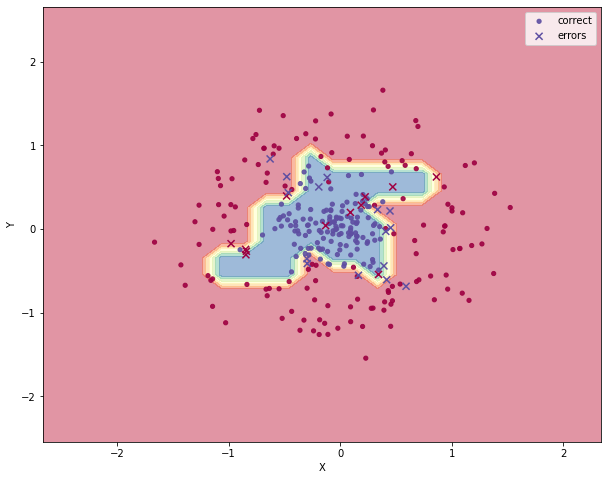

In [15]:
X, y = make_circles(300, factor=.1, noise=.3, random_state=23)
tree = ClassificationTree(criterion='entropy', min_leaf_size=10)
tree.fit(X, y)
plot_decision_surface(tree, X, y)

### Moons

Accuracy = 0.898


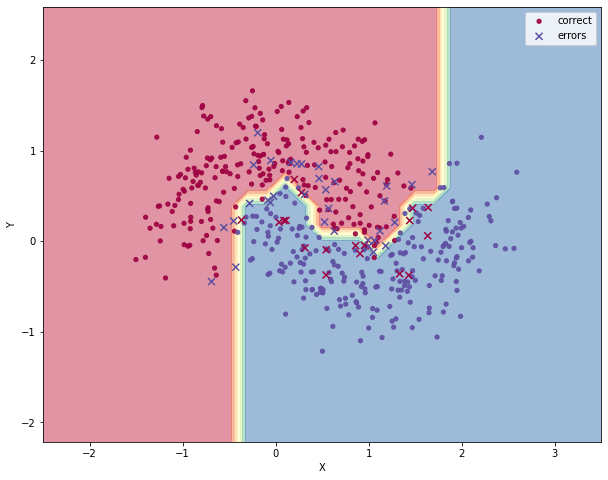

In [16]:
X, y = make_moons(500, noise=0.3, random_state=23)
tree = ClassificationTree(criterion='entropy', min_leaf_size=10)
tree.fit(X, y)
plot_decision_surface(tree, X, y)

## Regression

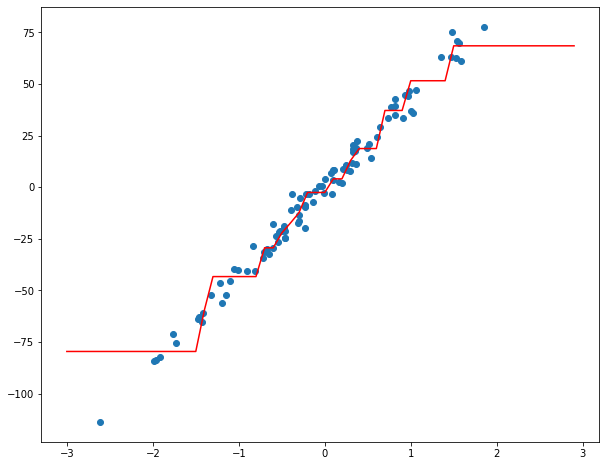

In [17]:
X, y = make_regression(n_samples=100, n_features=1, random_state=42, noise = 5)
tree = RegressionTree(min_leaf_size=10)
tree.fit(X, y)
plot_regression(tree, X, y)